# VGG for Cifar-10

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

### define loss tracker

In [3]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             ) 

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
vis.images(images/2 + 0.5)

# show images
#imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

truck   dog horse truck


### make VGG16

In [7]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [8]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers) 

In [9]:
# 13(Conv) + 3(Classifier) = vgg16
cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M']  

In [10]:
vgg16= VGG(make_layers(cfg),10,True).to(device) 

In [11]:
a=torch.Tensor(1,3,32,32).to(device)
out = vgg16(a)
print(out)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [16]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005, momentum=0.9)

lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

### make plot

In [13]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

### Train

In [14]:
print(len(trainloader))
epochs = 50

391


In [17]:
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
        
print('Finished Training')

C:\Users\ckkim\.conda\envs\vsc\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,    30] loss: 2.302
[1,    60] loss: 2.300
[1,    90] loss: 2.285
[1,   120] loss: 2.208
[1,   150] loss: 2.151
[1,   180] loss: 2.131
[1,   210] loss: 2.085
[1,   240] loss: 2.054
[1,   270] loss: 1.978
[1,   300] loss: 1.995
[1,   330] loss: 1.846
[1,   360] loss: 1.787
[1,   390] loss: 1.752
[2,    30] loss: 1.778
[2,    60] loss: 1.717
[2,    90] loss: 1.705
[2,   120] loss: 1.698
[2,   150] loss: 1.646
[2,   180] loss: 1.640
[2,   210] loss: 1.562
[2,   240] loss: 1.547
[2,   270] loss: 1.535
[2,   300] loss: 1.570
[2,   330] loss: 1.497
[2,   360] loss: 1.498
[2,   390] loss: 1.451
[3,    30] loss: 1.442
[3,    60] loss: 1.463
[3,    90] loss: 1.414
[3,   120] loss: 1.405
[3,   150] loss: 1.368
[3,   180] loss: 1.379
[3,   210] loss: 1.356
[3,   240] loss: 1.327
[3,   270] loss: 1.331
[3,   300] loss: 1.265
[3,   330] loss: 1.298
[3,   360] loss: 1.262
[3,   390] loss: 1.241
[4,    30] loss: 1.223
[4,    60] loss: 1.210
[4,    90] loss: 1.199
[4,   120] loss: 1.175
[4,   150] 

[27,   300] loss: 0.054
[27,   330] loss: 0.035
[27,   360] loss: 0.052
[27,   390] loss: 0.053
[28,    30] loss: 0.031
[28,    60] loss: 0.029
[28,    90] loss: 0.031
[28,   120] loss: 0.034
[28,   150] loss: 0.037
[28,   180] loss: 0.030
[28,   210] loss: 0.031
[28,   240] loss: 0.027
[28,   270] loss: 0.037
[28,   300] loss: 0.034
[28,   330] loss: 0.034
[28,   360] loss: 0.031
[28,   390] loss: 0.032
[29,    30] loss: 0.042
[29,    60] loss: 0.039
[29,    90] loss: 0.026
[29,   120] loss: 0.025
[29,   150] loss: 0.018
[29,   180] loss: 0.026
[29,   210] loss: 0.043
[29,   240] loss: 0.038
[29,   270] loss: 0.048
[29,   300] loss: 0.047
[29,   330] loss: 0.034
[29,   360] loss: 0.045
[29,   390] loss: 0.045
[30,    30] loss: 0.026
[30,    60] loss: 0.029
[30,    90] loss: 0.016
[30,   120] loss: 0.021
[30,   150] loss: 0.022
[30,   180] loss: 0.019
[30,   210] loss: 0.025
[30,   240] loss: 0.022
[30,   270] loss: 0.025
[30,   300] loss: 0.033
[30,   330] loss: 0.028
[30,   360] loss

![loss tracker](images/41_Cifar-10_Loss_Tracker.svg)

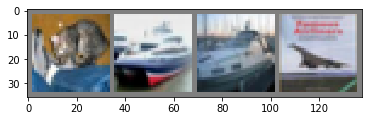

GroundTruth:    cat  ship  ship plane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4))) 

In [19]:
outputs = vgg16(images.to(device)) 

In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4))) 

Predicted:    cat  ship  ship plane


In [21]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %
